In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

In [3]:

cad = pd.read_csv('GMU_2021_Summer_CAD.csv')
avl = pd.read_csv('GMU_2021_Summer_AVL.csv')
avl.columns = ['AVL_IncidentNumber',
               'AVL_UnitID',
               'AVL_Timestamp',
               'AVL_UnitStatus',
               'AVL_Speed']
avl.dropna(subset = ['AVL_IncidentNumber'],
           inplace = True)
avl.reset_index(inplace = True, drop = True)
avl.isna().sum()

AVL_IncidentNumber    0
AVL_UnitID            0
AVL_Timestamp         0
AVL_UnitStatus        0
AVL_Speed             0
dtype: int64

In [4]:
# convert object to timestamp proper
avl['AVL_Timestamp'] = avl['AVL_Timestamp'].str.replace('ED', '')
cad['CAD_Timestamp'] = cad['CAD_Timestamp'].str.replace('ED', '')
avl['AVL_Timestamp'] = avl['AVL_Timestamp'].str.replace('ES', '')
cad['CAD_Timestamp'] = cad['CAD_Timestamp'].str.replace('ES', '')
avl['AVL_Timestamp'] = pd.to_datetime(avl['AVL_Timestamp'], format = '%Y%m%d%H%M%S')
cad['CAD_Timestamp'] = pd.to_datetime(cad['CAD_Timestamp'], format = '%Y%m%d%H%M%S')

In [5]:
#Create separate dat sets of ER and DP to then be joined to to form "transport" entry
cad_er = cad[cad['CAD_UnitStatus'].isin(['ER'])]
cad_dp= cad[cad['CAD_UnitStatus'].isin(['DP'])]
avl_er = avl[avl['AVL_UnitStatus'].isin(['ER'])]
avl_dp= avl[avl['AVL_UnitStatus'].isin(['DP'])]

In [6]:

#rename the columns so that that are labeled CAD or AVL and er or dp data frame
cad_er=cad_er.rename(columns={"CAD_IncidentNumber":"cad_er_IncidentNumber","CAD_UnitID":"cad_er_UnitID","CAD_Timestamp":"cad_er_Timestamp", "CAD_UnitStatus":"cad_er_UnitStatus"})
cad_dp=cad_dp.rename(columns={"CAD_IncidentNumber":"cad_dp_IncidentNumber","CAD_UnitID":"cad_dp_UnitID","CAD_Timestamp":"cad_dp_Timestamp", "CAD_UnitStatus":"cad_dp_UnitStatus"})

avl_er=avl_er.rename(columns={"AVL_IncidentNumber":"avl_er_IncidentNumber","AVL_UnitID":"avl_er_UnitID","AVL_Timestamp":"avl_er_Timestamp", "AVL_UnitStatus":"avl_er_UnitStatus", "AVL_Speed":"avl_er_Speed"})
avl_dp=avl_dp.rename(columns={"AVL_IncidentNumber":"avl_dp_IncidentNumber","AVL_UnitID":"avl_dp_UnitID","AVL_Timestamp":"avl_dp_Timestamp", "AVL_UnitStatus":"avl_dp_UnitStatus", "AVL_Speed":"avl_dp_Speed"})

In [7]:
#Create the FullKey to make sure the first time entry for the ER and DP status are being taken
cad_er['cad_er_FullKey'] = cad_er['cad_er_IncidentNumber'].map(str) +  cad_er['cad_er_UnitID'].map(str)
cad_dp['cad_dp_FullKey'] = cad_dp['cad_dp_IncidentNumber'].map(str) +  cad_dp['cad_dp_UnitID'].map(str)

avl_er['avl_er_FullKey'] = avl_er['avl_er_IncidentNumber'].map(str) +  avl_er['avl_er_UnitID'].map(str)
avl_dp['avl_dp_FullKey'] = avl_dp['avl_dp_IncidentNumber'].map(str) +  avl_dp['avl_dp_UnitID'].map(str)

#for validation note that there are currently duplicates in the data frames
dups_cad_er = cad_er.pivot_table(index = ['cad_er_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_cad_er)
dups_cad_dp = cad_dp.pivot_table(index = ['cad_dp_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_cad_dp)

dups_avl_er = avl_er.pivot_table(index = ['avl_er_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_avl_er)
dups_avl_dp = avl_dp.pivot_table(index = ['avl_dp_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_avl_dp)

In [8]:
#sort both dataframes by timestamp so when dups are removed taking the first time stamp
cad_er.sort_values(by='cad_er_Timestamp', ascending=True)
cad_dp.sort_values(by='cad_dp_Timestamp', ascending=True)

avl_er.sort_values(by='avl_er_Timestamp', ascending=True)
avl_dp.sort_values(by='avl_dp_Timestamp', ascending=True)

#Remove duplicates from each dataframe, so each unit ID is only DP or ER to an incident once
cad_er_NEW = cad_er.drop_duplicates(subset='cad_er_FullKey', keep="first", inplace=False)
cad_dp_NEW = cad_dp.drop_duplicates(subset='cad_dp_FullKey', keep="first", inplace=False)

avl_er_NEW = avl_er.drop_duplicates(subset='avl_er_FullKey', keep="first", inplace=False)
avl_dp_NEW = avl_dp.drop_duplicates(subset='avl_dp_FullKey', keep="first", inplace=False)

In [9]:
#join the CAD data framaes together and then the AVL dataframes together
df_cad = cad_dp_NEW.merge(cad_er_NEW, 
               how = 'inner', 
               left_on = ['cad_dp_IncidentNumber',
                          'cad_dp_UnitID'],
               right_on = ['cad_er_IncidentNumber',
                           'cad_er_UnitID'],
               suffixes = ('cad_dp', 'cad_er'))

df_avl = avl_dp_NEW.merge(avl_er_NEW, 
               how = 'inner', 
               left_on = ['avl_dp_IncidentNumber',
                          'avl_dp_UnitID'],
               right_on = ['avl_er_IncidentNumber',
                           'avl_er_UnitID'],
               suffixes = ('avl_dp', 'avl_er'))

In [10]:
# create turnout col in merged dataframe
df_cad['cad_Timestamp_Turnout'] = abs(df_cad['cad_er_Timestamp'] - df_cad['cad_dp_Timestamp'])

df_avl['avl_Timestamp_Turnout'] = abs(df_avl['avl_er_Timestamp'] - df_avl['avl_dp_Timestamp'])

In [11]:
df_ALL = df_avl.merge(df_cad, 
               how = 'inner', 
               left_on = ['avl_er_FullKey'],
               right_on = ['cad_er_FullKey'],
               suffixes = ('avl_er', 'cad_er'))

In [12]:
df_ALL['CAD_vs_AVL_Turnout'] = abs(df_ALL['avl_Timestamp_Turnout'] - df_ALL['cad_Timestamp_Turnout'])

In [13]:
df_ALL.head()

,avl_dp_IncidentNumber,avl_dp_UnitID,avl_dp_Timestamp,avl_dp_UnitStatus,avl_dp_Speed,avl_dp_FullKey,avl_er_IncidentNumber,avl_er_UnitID,avl_er_Timestamp,avl_er_UnitStatus,...,cad_dp_Timestamp,cad_dp_UnitStatus,cad_dp_FullKey,cad_er_IncidentNumber,cad_er_UnitID,cad_er_Timestamp,cad_er_UnitStatus,cad_er_FullKey,cad_Timestamp_Turnout,CAD_vs_AVL_Turnout
0,E192701006,E438,2019-09-27 09:49:51,DP,moving,E192701006E438,E192701006,E438,2019-09-27 09:50:38,ER,...,2019-09-27 09:47:37,DP,E192701006E438,E192701006,E438,2019-09-27 09:50:14,ER,E192701006E438,0 days 00:02:37,0 days 00:01:50
1,E192701055,M409B,2019-09-27 10:01:21,DP,not moving,E192701055M409B,E192701055,M409B,2019-09-27 10:02:33,ER,...,2019-09-27 10:00:46,DP,E192701055M409B,E192701055,M409B,2019-09-27 10:01:47,ER,E192701055M409B,0 days 00:01:01,0 days 00:00:11
2,E192701150,T438,2019-09-27 10:40:31,DP,moving,E192701150T438,E192701150,T438,2019-09-27 10:41:47,ER,...,2019-09-27 10:40:16,DP,E192701150T438,E192701150,T438,2019-09-27 10:40:32,ER,E192701150T438,0 days 00:00:16,0 days 00:01:00
3,E192701164,E410,2019-09-27 10:46:27,DP,not moving,E192701164E410,E192701164,E410,2019-09-27 10:47:24,ER,...,2019-09-27 10:45:24,DP,E192701164E410,E192701164,E410,2019-09-27 10:46:48,ER,E192701164E410,0 days 00:01:24,0 days 00:00:27
4,E192701227,M408B,2019-09-27 11:08:12,DP,not moving,E192701227M408B,E192701227,M408B,2019-09-27 11:12:04,ER,...,2019-09-27 11:06:12,DP,E192701227M408B,E192701227,M408B,2019-09-27 11:11:32,ER,E192701227M408B,0 days 00:05:20,0 days 00:01:28


In [14]:
trucks = df_ALL[df_ALL['avl_dp_UnitID'].str.startswith('T')]

In [15]:
trucks.head()

,avl_dp_IncidentNumber,avl_dp_UnitID,avl_dp_Timestamp,avl_dp_UnitStatus,avl_dp_Speed,avl_dp_FullKey,avl_er_IncidentNumber,avl_er_UnitID,avl_er_Timestamp,avl_er_UnitStatus,...,cad_dp_Timestamp,cad_dp_UnitStatus,cad_dp_FullKey,cad_er_IncidentNumber,cad_er_UnitID,cad_er_Timestamp,cad_er_UnitStatus,cad_er_FullKey,cad_Timestamp_Turnout,CAD_vs_AVL_Turnout
2,E192701150,T438,2019-09-27 10:40:31,DP,moving,E192701150T438,E192701150,T438,2019-09-27 10:41:47,ER,...,2019-09-27 10:40:16,DP,E192701150T438,E192701150,T438,2019-09-27 10:40:32,ER,E192701150T438,0 days 00:00:16,0 days 00:01:00
7,E192701369,TL440,2019-09-27 12:00:19,DP,moving,E192701369TL440,E192701369,TL440,2019-09-27 12:01:13,ER,...,2019-09-27 11:58:08,DP,E192701369TL440,E192701369,TL440,2019-09-27 12:00:32,ER,E192701369TL440,0 days 00:02:24,0 days 00:01:30
9,E192701577,TL424,2019-09-27 13:17:14,DP,moving,E192701577TL424,E192701577,TL424,2019-09-27 13:17:40,ER,...,2019-09-27 13:17:10,DP,E192701577TL424,E192701577,TL424,2019-09-27 13:17:15,ER,E192701577TL424,0 days 00:00:05,0 days 00:00:21
23,E192702666,TT425,2019-09-27 19:45:54,DP,moving,E192702666TT425,E192702666,TT425,2019-09-27 19:46:35,ER,...,2019-09-27 19:45:54,DP,E192702666TT425,E192702666,TT425,2019-09-27 19:46:02,ER,E192702666TT425,0 days 00:00:08,0 days 00:00:33
34,E192710183,TT425,2019-09-28 02:39:40,DP,moving,E192710183TT425,E192710183,TT425,2019-09-28 02:39:55,ER,...,2019-09-28 02:39:41,DP,E192710183TT425,E192710183,TT425,2019-09-28 02:39:46,ER,E192710183TT425,0 days 00:00:05,0 days 00:00:10


In [16]:
df_ALL['Apparatus'] = df_ALL['avl_dp_UnitID'].astype(str).str[0]

In [17]:
df_ALL['Apparatus'].unique()

array(['E', 'M', 'T', 'R', 'A'], dtype=object)

In [18]:
engines = df_ALL[df_ALL['Apparatus'].isin(['E'])]
medics= df_ALL[df_ALL['Apparatus'].isin(['M'])]
trucks = df_ALL[df_ALL['Apparatus'].isin(['T'])]
rescueSquad= df_ALL[df_ALL['Apparatus'].isin(['R'])]
ambulance= df_ALL[df_ALL['Apparatus'].isin(['A'])]

In [19]:
engines.head()

,avl_dp_IncidentNumber,avl_dp_UnitID,avl_dp_Timestamp,avl_dp_UnitStatus,avl_dp_Speed,avl_dp_FullKey,avl_er_IncidentNumber,avl_er_UnitID,avl_er_Timestamp,avl_er_UnitStatus,...,cad_dp_UnitStatus,cad_dp_FullKey,cad_er_IncidentNumber,cad_er_UnitID,cad_er_Timestamp,cad_er_UnitStatus,cad_er_FullKey,cad_Timestamp_Turnout,CAD_vs_AVL_Turnout,Apparatus
0,E192701006,E438,2019-09-27 09:49:51,DP,moving,E192701006E438,E192701006,E438,2019-09-27 09:50:38,ER,...,DP,E192701006E438,E192701006,E438,2019-09-27 09:50:14,ER,E192701006E438,0 days 00:02:37,0 days 00:01:50,E
3,E192701164,E410,2019-09-27 10:46:27,DP,not moving,E192701164E410,E192701164,E410,2019-09-27 10:47:24,ER,...,DP,E192701164E410,E192701164,E410,2019-09-27 10:46:48,ER,E192701164E410,0 days 00:01:24,0 days 00:00:27,E
5,E192701267,E431,2019-09-27 11:21:24,DP,moving,E192701267E431,E192701267,E431,2019-09-27 11:21:44,ER,...,DP,E192701267E431,E192701267,E431,2019-09-27 11:21:40,ER,E192701267E431,0 days 00:00:29,0 days 00:00:09,E
6,E192701282,E426,2019-09-27 11:28:12,DP,not moving,E192701282E426,E192701282,E426,2019-09-27 11:29:32,ER,...,DP,E192701282E426,E192701282,E426,2019-09-27 11:28:20,ER,E192701282E426,0 days 00:00:31,0 days 00:00:49,E
8,E192701391,E421,2019-09-27 12:06:10,DP,not moving,E192701391E421,E192701391,E421,2019-09-27 12:07:16,ER,...,DP,E192701391E421,E192701391,E421,2019-09-27 12:25:34,ER,E192701391E421,0 days 00:19:55,0 days 00:18:49,E


In [20]:
twentyfiveEngines = engines.cad_Timestamp_Turnout.quantile(0.25)
fiftyEngines = engines.cad_Timestamp_Turnout.quantile(0.5)
ninetyEngines = engines.cad_Timestamp_Turnout.quantile(0.9)
print ("\n25th Percentile for Engines Turnout (CAD): ", twentyfiveEngines)
print ("\n50th Percentile for Engines Turnout (CAD): ", fiftyEngines)
print ("\n90th Percentile for Engines Turnout (CAD): ", ninetyEngines)

twentyfiveEnginesA = engines.avl_Timestamp_Turnout.quantile(0.25)
fiftyEnginesA = engines.avl_Timestamp_Turnout.quantile(0.5)
ninetyEnginesA = engines.avl_Timestamp_Turnout.quantile(0.9)
print ("\n25th Percentile for Engines Turnout (AVL): ", twentyfiveEnginesA)
print ("\n50th Percentile for Engines Turnout (AVL): ", fiftyEnginesA)
print ("\n90th Percentile for Engines Turnout (AVL): ", ninetyEnginesA)


25th Percentile for Engines Turnout (CAD):  0 days 00:00:21

50th Percentile for Engines Turnout (CAD):  0 days 00:01:02

90th Percentile for Engines Turnout (CAD):  0 days 00:02:06

25th Percentile for Engines Turnout (AVL):  0 days 00:00:31

50th Percentile for Engines Turnout (AVL):  0 days 00:01:00

90th Percentile for Engines Turnout (AVL):  0 days 00:02:13


In [21]:
twentyfiveMedics = medics.cad_Timestamp_Turnout.quantile(0.25)
fiftyMedics = medics.cad_Timestamp_Turnout.quantile(0.5)
ninetyMedics = medics.cad_Timestamp_Turnout.quantile(0.9)
print ("\n25th Percentile for Medics Turnout (CAD): ", twentyfiveMedics)
print ("\n50th Percentile for Medics Turnout (CAD): ", fiftyMedics)
print ("\n90th Percentile for Medics Turnout (CAD): ", ninetyMedics)

twentyfiveMedicsA = medics.avl_Timestamp_Turnout.quantile(0.25)
fiftyMedicsA = medics.avl_Timestamp_Turnout.quantile(0.5)
ninetyMedicsA = medics.avl_Timestamp_Turnout.quantile(0.9)
print ("\n25th Percentile for Medics Turnout (AVL): ", twentyfiveMedicsA)
print ("\n50th Percentile for Medics Turnout (AVL): ", fiftyMedicsA)
print ("\n90th Percentile for Medics Turnout (AVL): ", ninetyMedicsA)



25th Percentile for Medics Turnout (CAD):  0 days 00:00:10

50th Percentile for Medics Turnout (CAD):  0 days 00:00:45

90th Percentile for Medics Turnout (CAD):  0 days 00:01:58

25th Percentile for Medics Turnout (AVL):  0 days 00:00:24

50th Percentile for Medics Turnout (AVL):  0 days 00:00:53

90th Percentile for Medics Turnout (AVL):  0 days 00:02:12


In [22]:
twentyfiveTrucks = trucks.cad_Timestamp_Turnout.quantile(0.25)
fiftyTrucks = trucks.cad_Timestamp_Turnout.quantile(0.5)
ninetyTrucks = trucks.cad_Timestamp_Turnout.quantile(0.9)
print ("\n25th Percentile for Trucks Turnout (CAD): ", twentyfiveTrucks)
print ("\n50th Percentile for Trucks Turnout (CAD): ", fiftyTrucks)
print ("\n90th Percentile for Trucks Turnout (CAD): ", ninetyTrucks)

twentyfiveTrucksA = trucks.avl_Timestamp_Turnout.quantile(0.25)
fiftyTrucksA = trucks.avl_Timestamp_Turnout.quantile(0.5)
ninetyTrucksA = trucks.avl_Timestamp_Turnout.quantile(0.9)
print ("\n25th Percentile for Trucks Turnout (AVL): ", twentyfiveTrucksA)
print ("\n50th Percentile for Trucks Turnout (AVL): ", fiftyTrucksA)
print ("\n90th Percentile for Trucks Turnout (AVL): ", ninetyTrucksA)



25th Percentile for Trucks Turnout (CAD):  0 days 00:00:13

50th Percentile for Trucks Turnout (CAD):  0 days 00:00:53

90th Percentile for Trucks Turnout (CAD):  0 days 00:02:07

25th Percentile for Trucks Turnout (AVL):  0 days 00:00:28

50th Percentile for Trucks Turnout (AVL):  0 days 00:00:58

90th Percentile for Trucks Turnout (AVL):  0 days 00:02:25


In [23]:
twentyfiveRescueSquad = rescueSquad.cad_Timestamp_Turnout.quantile(0.25)
fiftyRescueSquad = rescueSquad.cad_Timestamp_Turnout.quantile(0.5)
ninetyRescueSquad = rescueSquad.cad_Timestamp_Turnout.quantile(0.9)
print ("\n25th Percentile for RescueSquad Turnout (CAD): ", twentyfiveRescueSquad)
print ("\n50th Percentile for RescueSquad Turnout (CAD): ", fiftyRescueSquad)
print ("\n90th Percentile for RescueSquad Turnout (CAD): ", ninetyRescueSquad)

twentyfiveRescueSquadA = rescueSquad.avl_Timestamp_Turnout.quantile(0.25)
fiftyRescueSquadA = rescueSquad.avl_Timestamp_Turnout.quantile(0.5)
ninetyRescueSquadA = rescueSquad.avl_Timestamp_Turnout.quantile(0.9)
print ("\n25th Percentile for RescueSquad Turnout (AVL): ", twentyfiveRescueSquadA)
print ("\n50th Percentile for RescueSquad Turnout (AVL): ", fiftyRescueSquadA)
print ("\n90th Percentile for RescueSquad Turnout (AVL): ", ninetyRescueSquadA)



25th Percentile for RescueSquad Turnout (CAD):  0 days 00:00:11

50th Percentile for RescueSquad Turnout (CAD):  0 days 00:00:53

90th Percentile for RescueSquad Turnout (CAD):  0 days 00:01:55

25th Percentile for RescueSquad Turnout (AVL):  0 days 00:00:24

50th Percentile for RescueSquad Turnout (AVL):  0 days 00:00:50

90th Percentile for RescueSquad Turnout (AVL):  0 days 00:02:10


In [24]:
twentyfiveAmbulance = ambulance.cad_Timestamp_Turnout.quantile(0.25)
fiftyAmbulance = ambulance.cad_Timestamp_Turnout.quantile(0.5)
ninetyAmbulance = ambulance.cad_Timestamp_Turnout.quantile(0.9)
print ("\n25th Percentile for Ambulance Turnout (CAD): ", twentyfiveAmbulance)
print ("\n50th Percentile for Ambulance Turnout (CAD): ", fiftyAmbulance)
print ("\n90th Percentile for Ambulance Turnout (CAD): ", ninetyAmbulance)

twentyfiveAmbulanceA = ambulance.avl_Timestamp_Turnout.quantile(0.25)
fiftyAmbulanceA = ambulance.avl_Timestamp_Turnout.quantile(0.5)
ninetyAmbulanceA = ambulance.avl_Timestamp_Turnout.quantile(0.9)
print ("\n25th Percentile for Ambulance Turnout (AVL): ", twentyfiveAmbulanceA)
print ("\n50th Percentile for Ambulance Turnout (AVL): ", fiftyAmbulanceA)
print ("\n90th Percentile for Ambulance Turnout (AVL): ", ninetyAmbulanceA)



25th Percentile for Ambulance Turnout (CAD):  0 days 00:00:09

50th Percentile for Ambulance Turnout (CAD):  0 days 00:00:44

90th Percentile for Ambulance Turnout (CAD):  0 days 00:02:14

25th Percentile for Ambulance Turnout (AVL):  0 days 00:00:23

50th Percentile for Ambulance Turnout (AVL):  0 days 00:00:44

90th Percentile for Ambulance Turnout (AVL):  0 days 00:02:03


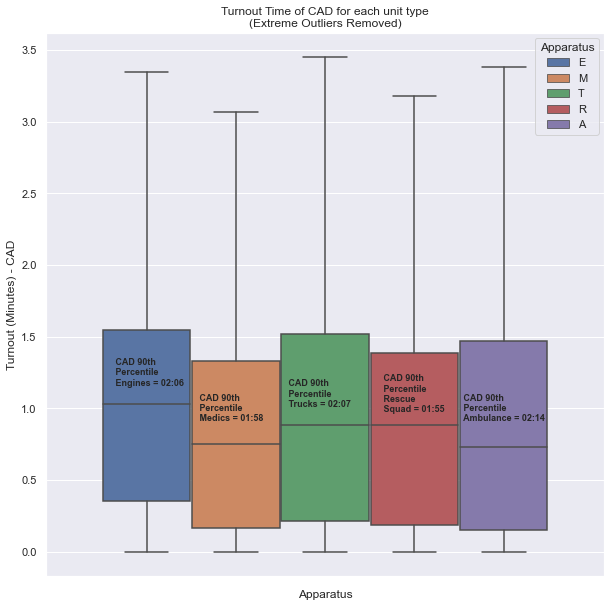

In [141]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


# ax = sns.boxplot(x = sort['delta'].dt.total_seconds()/60, y = [""] * len(sort), hue=sort["AVL_UnitStatus"], showfliers = False)  # RUN PLOT   
ax = sns.boxplot(y = df_ALL['cad_Timestamp_Turnout'].dt.total_seconds()/60, x = [""] * len(df_ALL), hue=df_ALL['Apparatus'],
                 showfliers = False,)
#                  whis = [0,90])  # RUN PLOT   

sns.set(rc={'figure.figsize':(10,10)})
plt.xlabel('Apparatus')
plt.ylabel('Turnout (Minutes) - CAD')
plt.title('Turnout Time of CAD for each unit type\n(Extreme Outliers Removed)')
plt.text(-.38,1.25,' CAD 90th \n Percentile \n Engines = 02:06', fontsize=9, horizontalalignment='left',
         verticalalignment='center', weight='bold')
plt.text(-.23,1.00,' CAD 90th \n Percentile \n Medics = 01:58', fontsize=9, horizontalalignment='left',
         verticalalignment='center', weight='bold')
plt.text(-.07,1.10,' CAD 90th \n Percentile \n Trucks = 02:07', fontsize=9, horizontalalignment='left',
         verticalalignment='center', weight='bold')
plt.text(.1,1.10,' CAD 90th \n Percentile \n Rescue \n Squad = 01:55', fontsize=9, horizontalalignment='left',
         verticalalignment='center', weight='bold')
plt.text(.244,1.00,' CAD 90th \n Percentile \n Ambulance = 02:14', fontsize=9, horizontalalignment='left',
         verticalalignment='center', weight='bold')
plt.show()

plt.clf()
plt.close()

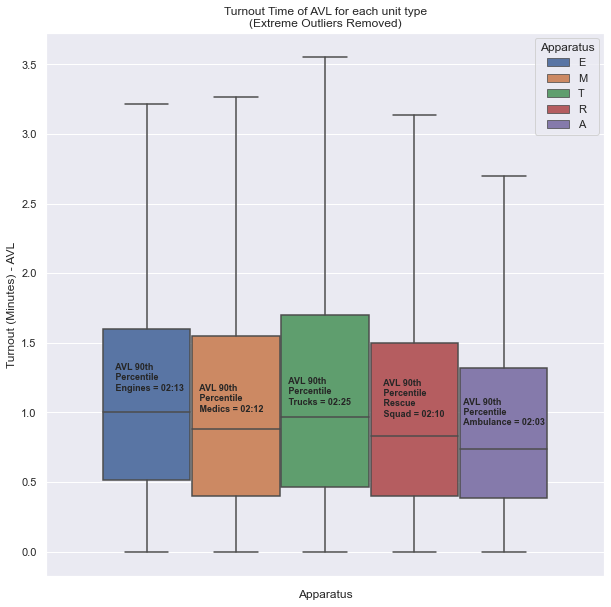

<Figure size 576x576 with 0 Axes>

In [135]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


# ax = sns.boxplot(x = sort['delta'].dt.total_seconds()/60, y = [""] * len(sort), hue=sort["AVL_UnitStatus"], showfliers = False)  # RUN PLOT   
ax = sns.boxplot(y = df_ALL['avl_Timestamp_Turnout'].dt.total_seconds()/60, x = [""] * len(df_ALL), hue=df_ALL['Apparatus'],
                 showfliers = False,)
#                  whis = [0,90])  # RUN PLOT   

sns.set(rc={'figure.figsize':(8,8)})
plt.xlabel('Apparatus')
plt.ylabel('Turnout (Minutes) - AVL')
plt.title('Turnout Time of AVL for each unit type\n(Extreme Outliers Removed)')
plt.text(-.38,1.25,' AVL 90th \n Percentile \n Engines = 02:13', fontsize=9, horizontalalignment='left',
         verticalalignment='center', weight='bold')
plt.text(-.23,1.1,' AVL 90th \n Percentile \n Medics = 02:12', fontsize=9, horizontalalignment='left',
         verticalalignment='center', weight='bold')
plt.text(-.07,1.15,' AVL 90th \n Percentile \n Trucks = 02:25', fontsize=9, horizontalalignment='left',
         verticalalignment='center', weight='bold')
plt.text(.1,1.10,' AVL 90th \n Percentile \n Rescue \n Squad = 02:10', fontsize=9, horizontalalignment='left',
         verticalalignment='center', weight='bold')
plt.text(.244,1.00,' AVL 90th \n Percentile \n Ambulance = 02:03', fontsize=9, horizontalalignment='left',
         verticalalignment='center', weight='bold')
plt.show()

plt.clf()
# plt.close()

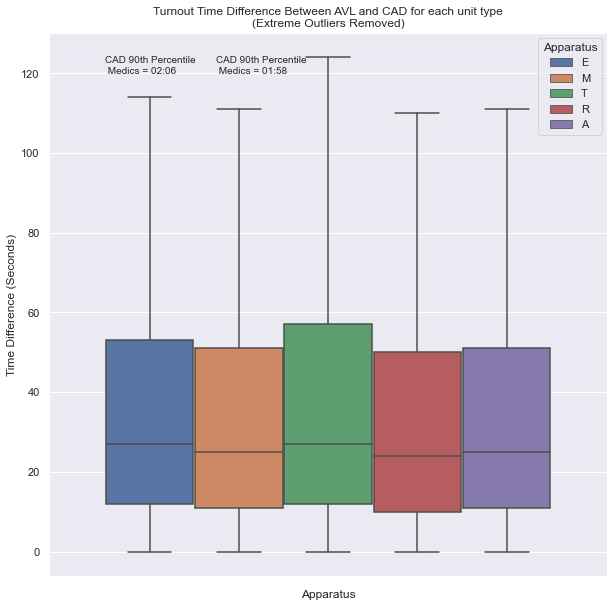

<Figure size 720x720 with 0 Axes>

In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


# ax = sns.boxplot(x = sort['delta'].dt.total_seconds()/60, y = [""] * len(sort), hue=sort["AVL_UnitStatus"], showfliers = False)  # RUN PLOT   
ax = sns.boxplot(y = df_ALL['CAD_vs_AVL_Turnout'].dt.total_seconds(), x = [""] * len(df_ALL), hue=df_ALL['Apparatus'],
                 showfliers = False,)
#                  whis = [0,90])  # RUN PLOT   

sns.set(rc={'figure.figsize':(10,10)})
plt.xlabel('Apparatus')
plt.ylabel('Time Difference (Seconds)')
plt.title('Turnout Time Difference Between AVL and CAD for each unit type\n(Extreme Outliers Removed)')
plt.show()

plt.clf()
# plt.close()

In [47]:
ambulance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 20 to 44371
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   avl_dp_IncidentNumber  481 non-null    object         
 1   avl_dp_UnitID          481 non-null    object         
 2   avl_dp_Timestamp       481 non-null    datetime64[ns] 
 3   avl_dp_UnitStatus      481 non-null    object         
 4   avl_dp_Speed           481 non-null    object         
 5   avl_dp_FullKey         481 non-null    object         
 6   avl_er_IncidentNumber  481 non-null    object         
 7   avl_er_UnitID          481 non-null    object         
 8   avl_er_Timestamp       481 non-null    datetime64[ns] 
 9   avl_er_UnitStatus      481 non-null    object         
 10  avl_er_Speed           481 non-null    object         
 11  avl_er_FullKey         481 non-null    object         
 12  avl_Timestamp_Turnout  481 non-null    timedelt

In [49]:
%matplotlib inline

In [107]:
cadTurn = df_ALL['cad_Timestamp_Turnout'].astype('timedelta64[s]')
avlTurn = df_ALL['avl_Timestamp_Turnout'].astype('timedelta64[s]')

In [108]:
type(cadTurn)

pandas.core.series.Series

In [116]:
cadTurn = cadTurn.to_frame()

In [122]:
cadTurn['bins'] = pd.cut(cadTurn['cad_Timestamp_Turnout'],bins=[pd.qcut(cadTurn['cad_Timestamp_Turnout'], q=4)], labels=["0-2 Minutes","3-5 Minutes","5+ Minutes"])
a = cadTurn['bins'].value_counts()

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

In [119]:
cadTurn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44415 entries, 0 to 44414
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   cad_Timestamp_Turnout  44415 non-null  float64 
 1   bins                   44238 non-null  category
dtypes: category(1), float64(1)
memory usage: 1.7 MB


In [123]:
binsQ = pd.qcut(cadTurn['cad_Timestamp_Turnout'], q=4)

In [127]:
binsQ = binsQ.to_frame()

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [129]:
binsQ = binsQ.rename(columns={"cad_Timestamp_Turnout":"Bin"})

In [132]:
binsQ['Bin'].unique()

[(88.0, 969584.0], (54.0, 88.0], (13.0, 54.0], (-0.001, 13.0]]
Categories (4, interval[float64]): [(-0.001, 13.0] < (13.0, 54.0] < (54.0, 88.0] < (88.0, 969584.0]]

In [147]:
df_CADless60 = df_ALL[df_ALL['cad_Timestamp_Turnout'].dt.total_seconds() <= 60]

In [146]:
df_ALL.head()

,avl_dp_IncidentNumber,avl_dp_UnitID,avl_dp_Timestamp,avl_dp_UnitStatus,avl_dp_Speed,avl_dp_FullKey,avl_er_IncidentNumber,avl_er_UnitID,avl_er_Timestamp,avl_er_UnitStatus,...,cad_dp_UnitStatus,cad_dp_FullKey,cad_er_IncidentNumber,cad_er_UnitID,cad_er_Timestamp,cad_er_UnitStatus,cad_er_FullKey,cad_Timestamp_Turnout,CAD_vs_AVL_Turnout,Apparatus
0,E192701006,E438,2019-09-27 09:49:51,DP,moving,E192701006E438,E192701006,E438,2019-09-27 09:50:38,ER,...,DP,E192701006E438,E192701006,E438,2019-09-27 09:50:14,ER,E192701006E438,0 days 00:02:37,0 days 00:01:50,E
1,E192701055,M409B,2019-09-27 10:01:21,DP,not moving,E192701055M409B,E192701055,M409B,2019-09-27 10:02:33,ER,...,DP,E192701055M409B,E192701055,M409B,2019-09-27 10:01:47,ER,E192701055M409B,0 days 00:01:01,0 days 00:00:11,M
2,E192701150,T438,2019-09-27 10:40:31,DP,moving,E192701150T438,E192701150,T438,2019-09-27 10:41:47,ER,...,DP,E192701150T438,E192701150,T438,2019-09-27 10:40:32,ER,E192701150T438,0 days 00:00:16,0 days 00:01:00,T
3,E192701164,E410,2019-09-27 10:46:27,DP,not moving,E192701164E410,E192701164,E410,2019-09-27 10:47:24,ER,...,DP,E192701164E410,E192701164,E410,2019-09-27 10:46:48,ER,E192701164E410,0 days 00:01:24,0 days 00:00:27,E
4,E192701227,M408B,2019-09-27 11:08:12,DP,not moving,E192701227M408B,E192701227,M408B,2019-09-27 11:12:04,ER,...,DP,E192701227M408B,E192701227,M408B,2019-09-27 11:11:32,ER,E192701227M408B,0 days 00:05:20,0 days 00:01:28,M


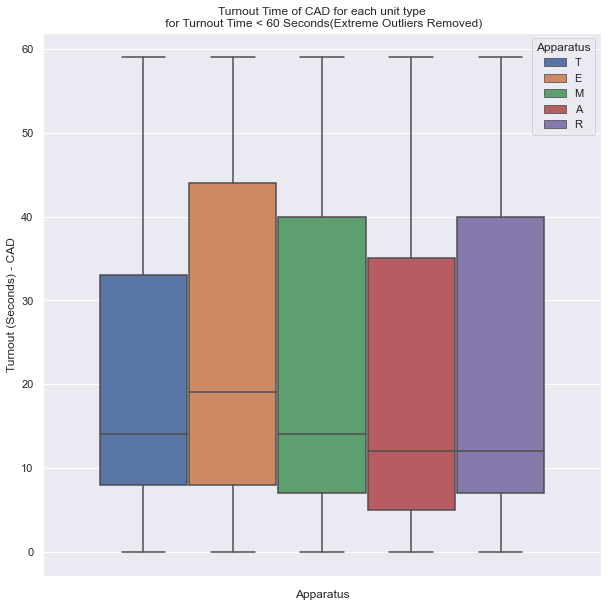

<Figure size 720x720 with 0 Axes>

In [149]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


# ax = sns.boxplot(x = sort['delta'].dt.total_seconds()/60, y = [""] * len(sort), hue=sort["AVL_UnitStatus"], showfliers = False)  # RUN PLOT   
ax = sns.boxplot(y = df_CADless60['cad_Timestamp_Turnout'].dt.total_seconds(), x = [""] * len(df_CADless60), hue=df_CADless60['Apparatus'],
                 showfliers = False,)
#                  whis = [0,90])  # RUN PLOT   

sns.set(rc={'figure.figsize':(10,10)})
plt.xlabel('Apparatus')
plt.ylabel('Turnout (Seconds) - CAD')
plt.title('Turnout Time of CAD for each unit type\n for Turnout Time < 60 Seconds(Extreme Outliers Removed)')
plt.show()

plt.clf()
# plt.close()

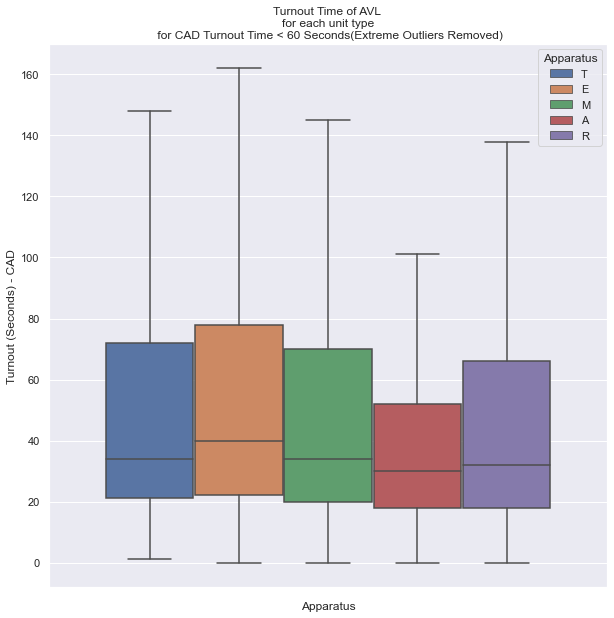

<Figure size 720x720 with 0 Axes>

In [150]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


# ax = sns.boxplot(x = sort['delta'].dt.total_seconds()/60, y = [""] * len(sort), hue=sort["AVL_UnitStatus"], showfliers = False)  # RUN PLOT   
ax = sns.boxplot(y = df_CADless60['avl_Timestamp_Turnout'].dt.total_seconds(), x = [""] * len(df_CADless60), hue=df_CADless60['Apparatus'],
                 showfliers = False,)
#                  whis = [0,90])  # RUN PLOT   

sns.set(rc={'figure.figsize':(10,10)})
plt.xlabel('Apparatus')
plt.ylabel('Turnout (Seconds) - CAD')
plt.title('Turnout Time of AVL \nfor each unit type\n for CAD Turnout Time < 60 Seconds(Extreme Outliers Removed)')
plt.show()

plt.clf()
# plt.close()

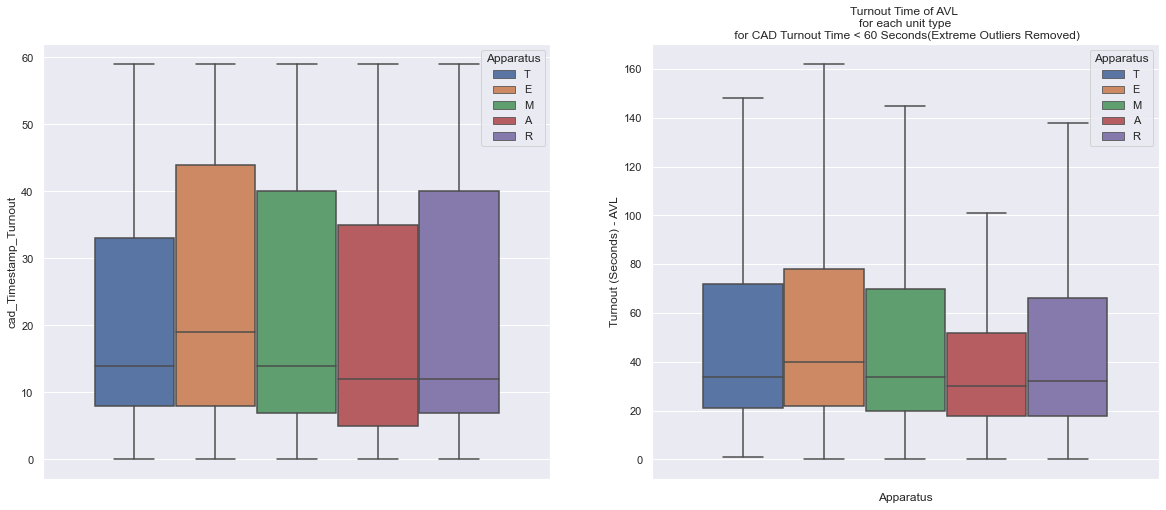

In [159]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False ,figsize=(20,8))


sns.boxplot(y = df_CADless60['cad_Timestamp_Turnout'].dt.total_seconds(), x = [""] * len(df_CADless60), hue=df_CADless60['Apparatus'],
                 showfliers = False,ax=ax1)
sns.set(rc={'figure.figsize':(10,10)})
plt.xlabel('Unit')
plt.ylabel('Turnout (Seconds) - CAD')
plt.title('Turnout Time of CAD for each unit type\n for Turnout Time < 60 Seconds(Extreme Outliers Removed)')

sns.boxplot(y = df_CADless60['avl_Timestamp_Turnout'].dt.total_seconds(), x = [""] * len(df_CADless60), hue=df_CADless60['Apparatus'],
                 showfliers = False,ax=ax2)
sns.set(rc={'figure.figsize':(10,10)})
plt.xlabel('Apparatus')
plt.ylabel('Turnout (Seconds) - AVL')
plt.title('Turnout Time of AVL \nfor each unit type\n for CAD Turnout Time < 60 Seconds(Extreme Outliers Removed)')

plt.show()

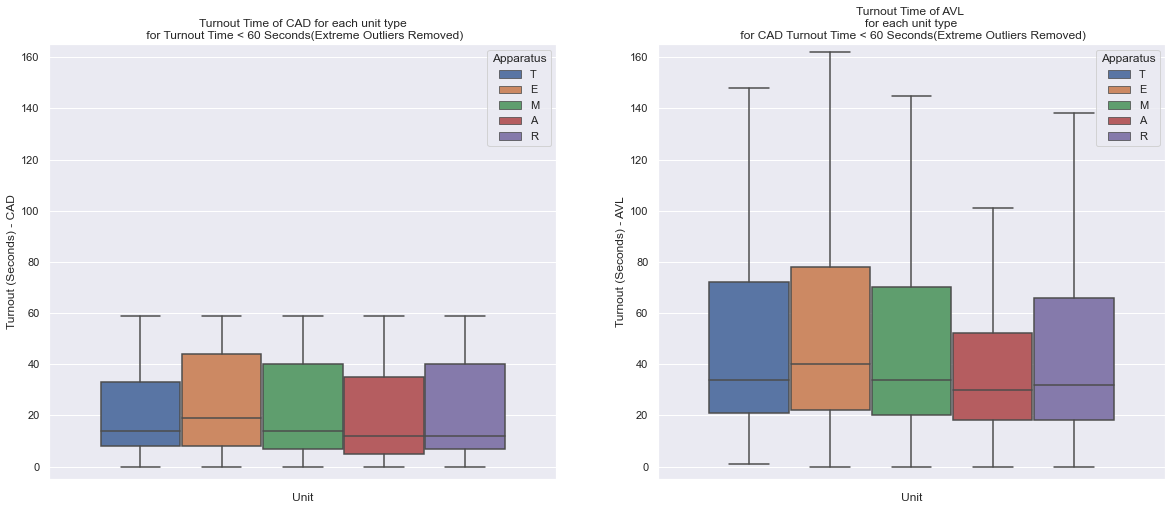

In [171]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

sns.boxplot(y = df_CADless60['cad_Timestamp_Turnout'].dt.total_seconds(), x = [""] * len(df_CADless60), hue=df_CADless60['Apparatus'],
                 showfliers = False,ax=ax1)
sns.set(rc={'figure.figsize':(10,10)})

sns.boxplot(y = df_CADless60['avl_Timestamp_Turnout'].dt.total_seconds(), x = [""] * len(df_CADless60), hue=df_CADless60['Apparatus'],
                 showfliers = False,ax=ax2)
sns.set(rc={'figure.figsize':(10,10)})

ax1.set_xlabel('Unit')
ax1.set_ylabel('Turnout (Seconds) - CAD')
ax2.set_xlabel('Unit')
ax2.set_ylabel('Turnout (Seconds) - AVL')
ax1.set_title('Turnout Time of CAD for each unit type\n for Turnout Time < 60 Seconds(Extreme Outliers Removed)')
ax2.set_title('Turnout Time of AVL \nfor each unit type\n for CAD Turnout Time < 60 Seconds(Extreme Outliers Removed)')
ax1.set_ylim([-5, 165])
ax2.set_ylim([-5, 165])

plt.show()